<a href="https://colab.research.google.com/github/rpedram/data-science/blob/main/Capston_Health_care.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capston Project Health care

### Import lib and data from csv

In [42]:
import pandas as pd
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For additional visualizations
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Get the file path from Google Drive
file_path = '/content/drive/My Drive/Dataset/'

# **1. Importing Data**
med_data = pd.read_csv(file_path+'Medical Examinations.csv')
hosp_data = pd.read_csv(file_path+'Hospitalisation details.csv')
names_data = pd.read_excel(file_path+'Names.xlsx')
# Check import is correct
med_data.head()
hosp_data.head()
names_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Customer ID,name
0,Id1,"Hawks, Ms. Kelly"
1,Id2,"Lehner, Mr. Matthew D"
2,Id3,"Lu, Mr. Phil"
3,Id4,"Osborne, Ms. Kelsey"
4,Id5,"Kadala, Ms. Kristyn"


### Combine data frames

In [43]:
# Identify merge columns (assuming Customer ID)
merge_col = 'Customer ID'

# Merge dataframes, handling potential duplicates and null values
merged_data = pd.merge(left=hosp_data, right=med_data, on=merge_col, how='inner')
merged_data = merged_data.merge(right=names_data, on=merge_col, how='inner')
# Are there duplicates ?
duplicateRows = merged_data[merged_data.duplicated()]
duplicateRows.head() # resulted in blank
# Handle duplicates after merging (not required as no duplicares)
# merged_data.drop_duplicates(inplace=True) -- code in case of duplicates
merged_data.dtypes

Customer ID                object
year                       object
month                      object
date                        int64
children                    int64
charges                   float64
Hospital tier              object
City tier                  object
State ID                   object
BMI                       float64
HBA1C                     float64
Heart Issues               object
Any Transplants            object
Cancer history             object
NumberOfMajorSurgeries     object
smoker                     object
name                       object
dtype: object

### Data wrangling


Missing value analysis

In [44]:
# Check for missing values
print(merged_data.isna().sum())
# I have no null values in merged data
merged_data.convert_dtypes() #  Converts dtypes auto
# Finding odd values
merged_data.columns
unique_values = merged_data["Customer ID"].unique()
print(unique_values)
merged_data[(merged_data == '?').all(axis=1)]
merged_data.info()
merged_data.head()

Customer ID               0
year                      0
month                     0
date                      0
children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
BMI                       0
HBA1C                     0
Heart Issues              0
Any Transplants           0
Cancer history            0
NumberOfMajorSurgeries    0
smoker                    0
name                      0
dtype: int64
['Id2335' 'Id2334' 'Id2333' ... 'Id3' 'Id2' 'Id1']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335 entries, 0 to 2334
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             2335 non-null   object 
 1   year                    2335 non-null   object 
 2   month                   2335 non-null   object 
 3   date                    2335 non-null   int64  
 4   children                2335 n

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,HBA1C,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P"
2,Id2333,1993,Jun,30,0,600.00,tier - 2,tier - 1,R1013,16.47,6.35,No,No,Yes,1,No,"Albano, Ms. Julie"
3,Id2332,1992,Sep,13,0,604.54,tier - 3,tier - 3,R1013,17.70,6.28,No,No,No,1,No,"Riveros Gonzalez, Mr. Juan D. Sr."
4,Id2331,1998,Jul,27,0,637.26,tier - 3,tier - 3,R1013,22.34,5.57,No,No,No,1,No,"Brietzke, Mr. Jordan"


Find the percentage of rows that have trivial value (for example, ?), and delete such rows if they do
not contain significant information

In [45]:
# Create a boolean mask for rows containing "?"
mask = merged_data.apply(lambda row: '?' in row.values, axis=1)

# Filter rows based on the mask
filtered_df = merged_data[mask]
print(filtered_df)
#There are only 10 rows with '?' so I can just delete them
merged_data=merged_data[~mask]
merged_data.shape
# Convert object columns to appropriate types
merged_data = merged_data.infer_objects()
merged_data.describe()
merged_data.sort_values(by='charges', ascending=True)  # Ascending order
merged_data.groupby('State ID')['charges'].sum()

     Customer ID  year month  date  children   charges Hospital tier  \
11        Id2324  1999   Dec    26         0    700.00             ?   
13        Id2322  2002     ?    19         0    750.00      tier - 3   
17        Id2318  1996     ?    18         0    770.38      tier - 3   
542       Id1793  1995   Dec     1         3   4827.90      tier - 1   
1046      Id1289     ?   Jul    24         0   8534.67      tier - 2   
1049      Id1286     ?   Dec    12         1   8547.69      tier - 2   
1700       Id635  2004   Jul    17         0  15518.18      tier - 2   
1775       Id560  1994   Jul     1         3  17663.14      tier - 1   
2165       Id170  2000   Sep     5         1  37165.16      tier - 1   
2332         Id3  1970     ?    11         3  60021.40      tier - 1   

     City tier State ID     BMI  HBA1C Heart Issues Any Transplants  \
11    tier - 3    R1013  22.240   5.04           No              No   
13    tier - 1    R1012  21.380   8.01           No              

State ID
R1011    11173625.27
R1012     6847930.72
R1013     6408232.33
R1014      175214.74
R1015      151865.14
R1016      869712.86
R1017      533019.88
R1018      119455.08
R1019      354461.73
R1020       55430.99
R1021      625336.47
R1022      149107.30
R1023      523873.67
R1024     2049889.25
R1025      351551.29
R1026     1049153.37
Name: charges, dtype: float64

now convert columns to required data type

In [46]:
merged_data.columns
columns_to_convert_int = ['year', 'date', 'children']

columns_to_convert_float = ['charges',  'BMI', 'HBA1C']


for col in columns_to_convert_int:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce').astype('Int64')

for col in columns_to_convert_float:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce').astype('float64')


# Print the updated DataFrame
print(merged_data)

     Customer ID  year month  date  children   charges Hospital tier  \
0         Id2335  1992   Jul     9         0    563.84      tier - 2   
1         Id2334  1992   Nov    30         0    570.62      tier - 2   
2         Id2333  1993   Jun    30         0    600.00      tier - 2   
3         Id2332  1992   Sep    13         0    604.54      tier - 3   
4         Id2331  1998   Jul    27         0    637.26      tier - 3   
...          ...   ...   ...   ...       ...       ...           ...   
2329         Id6  1962   Aug     4         0  52590.83      tier - 1   
2330         Id5  1989   Jun    19         0  55135.40      tier - 1   
2331         Id4  1991   Jun     6         1  58571.07      tier - 1   
2333         Id2  1977   Jun     8         0  62592.87      tier - 2   
2334         Id1  1968   Oct    12         0  63770.43      tier - 1   

     City tier State ID     BMI  HBA1C Heart Issues Any Transplants  \
0     tier - 3    R1013  17.580   4.51           No             

Data transformation
Convert to catagorical variables, The number of surgeries field convert to numeric

In [47]:
# replace 'No major surgery' in col 'NumberOfMajorSurgeries' by zero
merged_data['NumberOfMajorSurgeries']=merged_data['NumberOfMajorSurgeries'].replace('No major surgery',0)
merged_data['NumberOfMajorSurgeries'] = pd.to_numeric(merged_data['NumberOfMajorSurgeries'], errors='coerce').astype('Int64')

convert yes no fields to simple mapping for encoding

In [48]:
#First convert all these fields to lower case as there are Initiail capitals and allsmall mixed in fields
# inconcistancy in Yes/no field capitalisation
columns_to_convert = ['Heart Issues', 'Any Transplants', 'Cancer history','smoker']

for col in columns_to_convert:
    merged_data[col] = merged_data[col].str.lower()

# Print the updated DataFrame
print(merged_data)
def encode_yes_no(column):
    return column.map({'yes': 0, 'no': 1})

merged_data['Heart Issues'] = encode_yes_no(merged_data['Heart Issues'])
merged_data['Any Transplants'] = encode_yes_no(merged_data['Any Transplants'])
merged_data['Cancer history'] = encode_yes_no(merged_data['Cancer history'])
merged_data['smoker'] = encode_yes_no(merged_data['smoker'])


     Customer ID  year month  date  children   charges Hospital tier  \
0         Id2335  1992   Jul     9         0    563.84      tier - 2   
1         Id2334  1992   Nov    30         0    570.62      tier - 2   
2         Id2333  1993   Jun    30         0    600.00      tier - 2   
3         Id2332  1992   Sep    13         0    604.54      tier - 3   
4         Id2331  1998   Jul    27         0    637.26      tier - 3   
...          ...   ...   ...   ...       ...       ...           ...   
2329         Id6  1962   Aug     4         0  52590.83      tier - 1   
2330         Id5  1989   Jun    19         0  55135.40      tier - 1   
2331         Id4  1991   Jun     6         1  58571.07      tier - 1   
2333         Id2  1977   Jun     8         0  62592.87      tier - 2   
2334         Id1  1968   Oct    12         0  63770.43      tier - 1   

     City tier State ID     BMI  HBA1C Heart Issues Any Transplants  \
0     tier - 3    R1013  17.580   4.51           no             

Encoding city tier and hospital tier by label encoding as this is ordinal data

In [49]:
# Function for label encoding a column
def encode_column(column_name):
    encoder = LabelEncoder()
    merged_data[column_name + '_encoded'] = encoder.fit_transform(merged_data[column_name])

# Apply the encoding to both columns
encode_column('Hospital tier')
encode_column('City tier')

print(merged_data)

     Customer ID  year month  date  children   charges Hospital tier  \
0         Id2335  1992   Jul     9         0    563.84      tier - 2   
1         Id2334  1992   Nov    30         0    570.62      tier - 2   
2         Id2333  1993   Jun    30         0    600.00      tier - 2   
3         Id2332  1992   Sep    13         0    604.54      tier - 3   
4         Id2331  1998   Jul    27         0    637.26      tier - 3   
...          ...   ...   ...   ...       ...       ...           ...   
2329         Id6  1962   Aug     4         0  52590.83      tier - 1   
2330         Id5  1989   Jun    19         0  55135.40      tier - 1   
2331         Id4  1991   Jun     6         1  58571.07      tier - 1   
2333         Id2  1977   Jun     8         0  62592.87      tier - 2   
2334         Id1  1968   Oct    12         0  63770.43      tier - 1   

     City tier State ID     BMI  HBA1C  Heart Issues  Any Transplants  \
0     tier - 3    R1013  17.580   4.51             1          

The dataset has State ID, which has around 16 states. All states are not represented in equal
proportions in the data. Creating dummy variables for all regions may also result in too many
insignificant predictors. Nevertheless, only R1011, R1012, and R1013 are worth investigating
further. Design a suitable strategy to create dummy variables with these restraints.

In [50]:
# Create dummy variables, dropping the first column to avoid redundancy
merged_data['State ID'].unique()
dummies = pd.get_dummies(merged_data['State ID'], prefix='State')

#debug
print(dummies.head())
print(dummies.columns)
# Filter for desired state IDs
dummies = dummies[['State_R1011', 'State_R1012', 'State_R1013']]

# Concatenate with the original DataFrame
merged_data = pd.concat([merged_data, dummies], axis=1)


   State_R1011  State_R1012  State_R1013  State_R1014  State_R1015  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   State_R1016  State_R1017  State_R1018  State_R1019  State_R1020  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   State_R1021  State_R1022  State_R1023  State_R1024  State_R1025  \
0            0            0            0            0            0   
1            0    

Make a field 'dob for date of bith from three fields date, year month

In [51]:
import datetime
merged_data['City tier'].unique()
merged_data.info()
merged_data.isnull().sum()
# Convert month abbreviations to numeric month values
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
merged_data['month'] = merged_data['month'].map(month_mapping)
#rename the column date to day as this gives error while converting to date
#wasted many hours
merged_data.rename(columns={'date': 'day'}, inplace=True)
#debug
#df=merged_data['month'].map(month_mapping)
#print(df.unique())
#df.astype(np.int64)
# Combine day, month, and year columns into a single date column
#df=merged_data[['year','month','date']]
#print(df)
#df.notna().sum()
merged_data['dob'] = pd.to_datetime(merged_data[['day','month', 'year']], format='%d-%m-%Y')

# Print the updated DataFrame
print(merged_data['dob'])
merged_data['dob'] = pd.to_datetime(merged_data['dob'])
#Now convert the dob into age in decimal format
#function to claculate decimal age
def calculate_decimal_age(born):
    today = datetime.date.today()
    #subtract current year from birth year and adjust if your birthday has past in current year
    years = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    days = (today.day - born.day)
    return years + days / 365.25  # Adjust for leap years

merged_data['age'] = merged_data['dob'].apply(calculate_decimal_age)
print(merged_data['age'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2334
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             2325 non-null   object 
 1   year                    2325 non-null   Int64  
 2   month                   2325 non-null   object 
 3   date                    2325 non-null   Int64  
 4   children                2325 non-null   Int64  
 5   charges                 2325 non-null   float64
 6   Hospital tier           2325 non-null   object 
 7   City tier               2325 non-null   object 
 8   State ID                2325 non-null   object 
 9   BMI                     2325 non-null   float64
 10  HBA1C                   2325 non-null   float64
 11  Heart Issues            2325 non-null   int64  
 12  Any Transplants         2325 non-null   int64  
 13  Cancer history          2325 non-null   int64  
 14  NumberOfMajorSurgeries  2325 non-null   

Add gender field based on name

In [52]:
# Function to extract gender from name. Use this with apply()
# I Can also use lambada function to do this in one line of code. Try later
def extract_gender(name):
    if 'Mr.' in name:
        return 'Male'
    elif 'Ms.' in name or 'Mrs.' in name:
        return 'Female'
    else:
        return np.nan

merged_data['gender'] = merged_data['name'].apply(extract_gender)
print(merged_data['gender'])
merged_data['gender'].unique()
#Now label gender to categoric data
encode_column('gender')
merged_data.info()
merged_data.columns

0         Male
1         Male
2       Female
3         Male
4         Male
         ...  
2329      Male
2330    Female
2331    Female
2333      Male
2334    Female
Name: gender, Length: 2325, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2334
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Customer ID             2325 non-null   object        
 1   year                    2325 non-null   Int64         
 2   month                   2325 non-null   int64         
 3   day                     2325 non-null   Int64         
 4   children                2325 non-null   Int64         
 5   charges                 2325 non-null   float64       
 6   Hospital tier           2325 non-null   object        
 7   City tier               2325 non-null   object        
 8   State ID                2325 non-null   object        
 9   BMI                  

Index(['Customer ID', 'year', 'month', 'day', 'children', 'charges',
       'Hospital tier', 'City tier', 'State ID', 'BMI', 'HBA1C',
       'Heart Issues', 'Any Transplants', 'Cancer history',
       'NumberOfMajorSurgeries', 'smoker', 'name', 'Hospital tier_encoded',
       'City tier_encoded', 'State_R1011', 'State_R1012', 'State_R1013', 'dob',
       'age', 'gender', 'gender_encoded'],
      dtype='object')

### Data Visualization and Exploration (Week 1, Tasks 9-12):
visualize the distribution of costs using a histogram, box and whisker plot, and swarm plot.

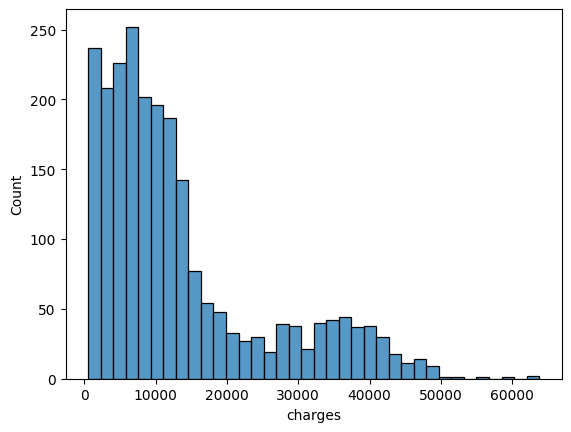

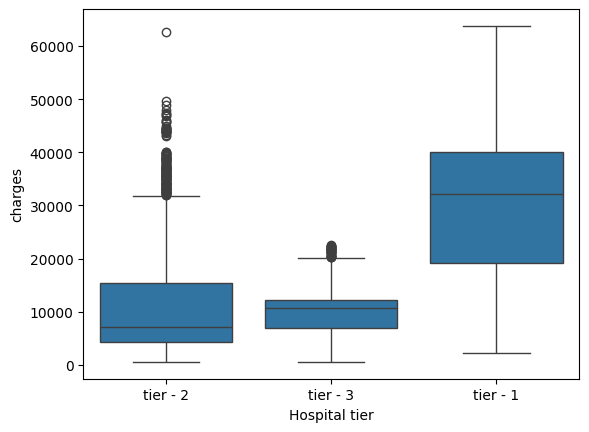

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 20.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 23.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 40.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 46.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


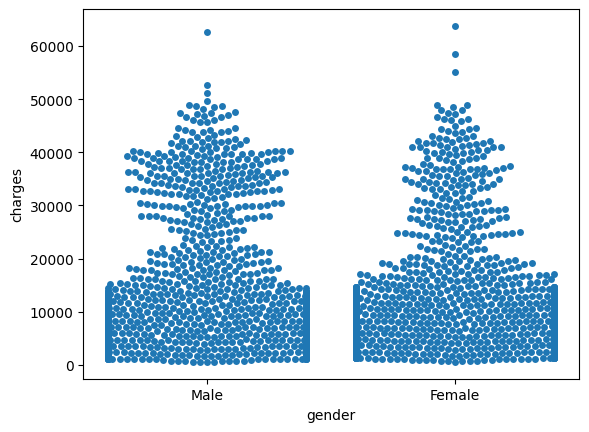

In [53]:
sns.histplot(merged_data['charges'])
plt.show()

sns.boxplot(x='Hospital tier', y='charges', data=merged_data)
plt.show()

sns.swarmplot(x='gender', y='charges', data=merged_data)
plt.show()


Remove outliers from charges field.
I have later found that this outlier removal is affecting accuracy of my model. So i am not executing the code in the next block.



In [54]:
'''
#I have drooped the idea of removing outliers as imacting model accuracy
Q1 = merged_data['charges'].quantile(0.25)
Q3 = merged_data['charges'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

filtered_df = merged_data[(merged_data['charges'] < upper_bound) & (merged_data['charges'] > lower_bound)]

#Check with plot
sns.histplot(filtered_df['charges'])
plt.show()

sns.boxplot(x='Hospital tier', y='charges', data=filtered_df)
plt.show()

sns.swarmplot(x='gender', y='charges', data=filtered_df)
plt.show()

# this looks of
filtered_df.head()
merged_data=filtered_df
merged_data.head()
'''

"\n#I have drooped the idea of removing outliers as imacting model accuracy\nQ1 = merged_data['charges'].quantile(0.25)\nQ3 = merged_data['charges'].quantile(0.75)\nIQR = Q3 - Q1\n\nupper_bound = Q3 + 1.5 * IQR\nlower_bound = Q1 - 1.5 * IQR\n\nfiltered_df = merged_data[(merged_data['charges'] < upper_bound) & (merged_data['charges'] > lower_bound)]\n\n#Check with plot\nsns.histplot(filtered_df['charges'])\nplt.show()\n\nsns.boxplot(x='Hospital tier', y='charges', data=filtered_df)\nplt.show()\n\nsns.swarmplot(x='gender', y='charges', data=filtered_df)\nplt.show()\n\n# this looks of\nfiltered_df.head()\nmerged_data=filtered_df\nmerged_data.head()\n"

[32097.435  7168.76  10676.83 ]


<ipython-input-55-dde530f7fc49>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=10)


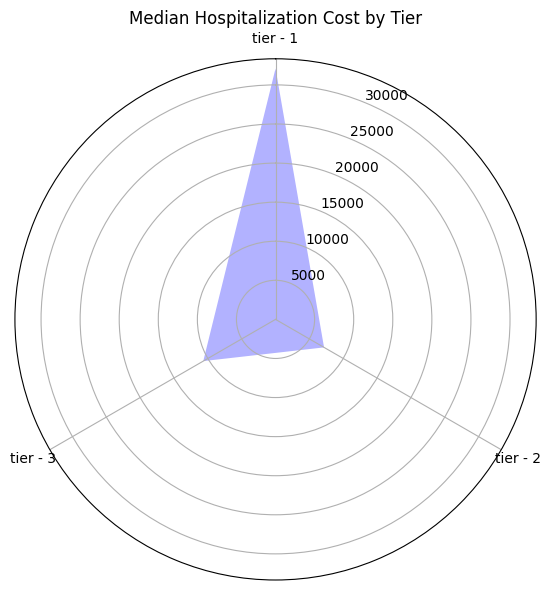

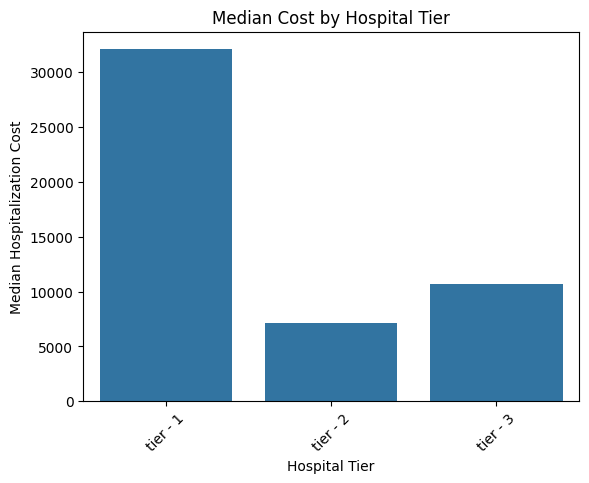

In [55]:

# Calculate median cost per hospital tier
median_costs = merged_data.groupby('Hospital tier')['charges'].median()
# Calculate medians for each tier
tiers = merged_data['Hospital tier'].unique()

# Create the radar chart
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'}) # polar is for circular
ax.set_aspect('equal')

# Set labels for each axis (hospital tier)
labels = ['tier - 1', 'tier - 2', 'tier - 3']

# Set data (median costs)
theta = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
radius = median_costs.values
print(radius)

# Plot the radar chart
ax.fill(theta, radius, 'b', alpha=0.3)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Median Hospitalization Cost by Tier', fontsize=12)
ax.set_xticklabels(labels, fontsize=10)
ax.set_xticks(theta)
plt.tight_layout()
plt.show()


# Create a bar plot for visualization
sns.barplot(x=median_costs.index, y=median_costs.values)
plt.xlabel('Hospital Tier')
plt.ylabel('Median Hospitalization Cost')
plt.title('Median Cost by Hospital Tier')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()


Create a frequency table and a stacked bar chart to visualize the count of people in the different tiers of cities and hospitals

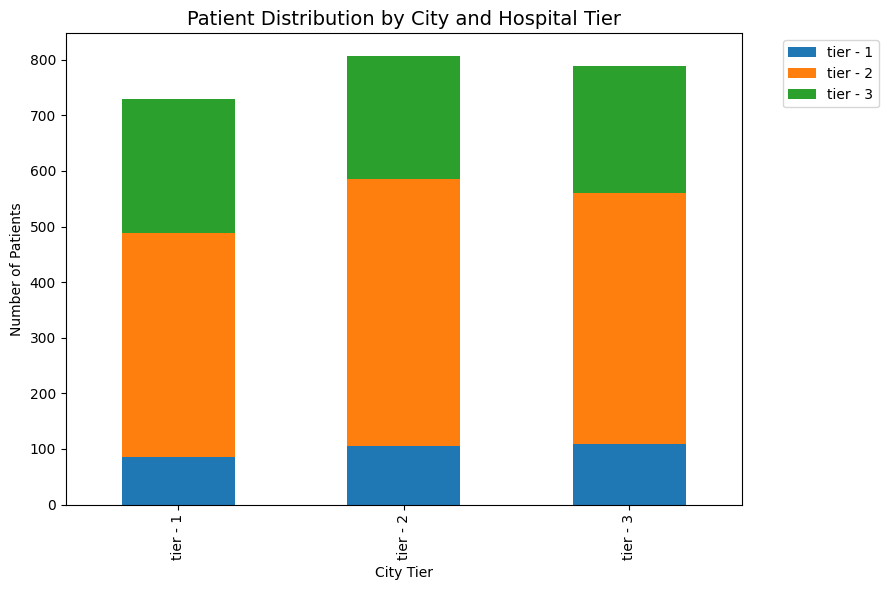

In [56]:
merged_data.columns
# Create a pivot table for ease of plotting
df_pivot = pd.pivot_table(merged_data, index='City tier', columns='Hospital tier', values='Customer ID', aggfunc='count')

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(9, 6))

df_pivot.plot.bar(stacked=True, ax=ax)

# Add title and labels
plt.title('Patient Distribution by City and Hospital Tier', fontsize=14)
plt.xlabel('City Tier')
plt.ylabel('Number of Patients')

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


### Hypothesis testing
The average hospitalization costs for the three types of hospitals are not significantly different.


In [57]:
merged_data.columns
merged_data['Heart Issues'].unique()
from scipy.stats import f_oneway
from scipy import stats

# Hospital tiers
group1 = merged_data[merged_data['Hospital tier'] == 'tier - 1']['charges']
group2 = merged_data[merged_data['Hospital tier'] == 'tier - 2']['charges']
group3 = merged_data[merged_data['Hospital tier'] == 'tier - 3']['charges']


f_statistic, pvalue = f_oneway(group1, group2, group3)
print('result of Annova Hospital tier')
print(f'Hosp tier: f statistics is {f_statistic} and the pvalue is {pvalue}')

#Hypothesis city tier
#Null hypothesis no significant difference in costs in types of city
group1 = merged_data[merged_data['City tier'] == 'tier - 1']['charges']
group2 = merged_data[merged_data['City tier'] == 'tier - 2']['charges']
group3 = merged_data[merged_data['City tier'] == 'tier - 3']['charges']


f_statistic, pvalue = f_oneway(group1, group2, group3)
print('result of Annova City tier cost')
print(f'City Tier: f statistics is {f_statistic} and the pvalue is {pvalue}')
#Null hypothesis proved

# Hypothesis 2
# Avg cost of smokers not diff from Non smokers
from scipy.stats import ttest_ind

smokers = merged_data[merged_data['smoker'] == 0]['charges']
non_smokers = merged_data[merged_data['smoker'] == 1]['charges']

t_statistic, pvalue = ttest_ind(smokers, non_smokers)
print('result of T test for smokers')
print(f'Smoker: f statistics is {f_statistic} and the pvalue is {pvalue}')

# Hypothesis 3
# Smoking and Heart issues are independent
#Use Chi square test
contingency = pd.crosstab(merged_data['smoker'], merged_data['Heart Issues'])
chi_square, pvalue, dof, expected = stats.chi2_contingency(contingency)
print('result of Chi Square test for smokers')
print(f'Smoker: Chisquare value is {chi_square} and the pvalue is {pvalue}')


result of Annova Hospital tier
Hosp tier: f statistics is 493.98956631117636 and the pvalue is 1.7738221310852664e-179
result of Annova City tier cost
City Tier: f statistics is 1.4543557561814688 and the pvalue is 0.23376344386881315
result of T test for smokers
Smoker: f statistics is 1.4543557561814688 and the pvalue is 0.0
result of Chi Square test for smokers
Smoker: Chisquare value is 0.08588150449910656 and the pvalue is 0.7694797581780767


### Correlation Analysis
Examine the correlation between predictors to identify highly correlated predictors

                        children   charges       BMI     HBA1C  Heart Issues  \
children                1.000000  0.055901 -0.005339 -0.101379     -0.023984   
charges                 0.055901  1.000000  0.346730  0.139697     -0.049299   
BMI                    -0.005339  0.346730  1.000000 -0.006920     -0.017129   
HBA1C                  -0.101379  0.139697 -0.006920  1.000000     -0.007699   
Heart Issues           -0.023984 -0.049299 -0.017129 -0.007699      1.000000   
Any Transplants         0.142040  0.127028 -0.015893  0.159855     -0.140269   
Cancer history          0.027880  0.022522  0.020235  0.170921      0.111190   
NumberOfMajorSurgeries -0.113161  0.053308  0.018851 -0.091594     -0.206147   
smoker                 -0.017713 -0.838462 -0.107126 -0.007257     -0.007159   
Hospital tier_encoded  -0.052438 -0.446687 -0.104771  0.057855     -0.053376   
City tier_encoded      -0.015760  0.035300  0.038123 -0.005404     -0.023152   
State_R1011             0.011666  0.2869

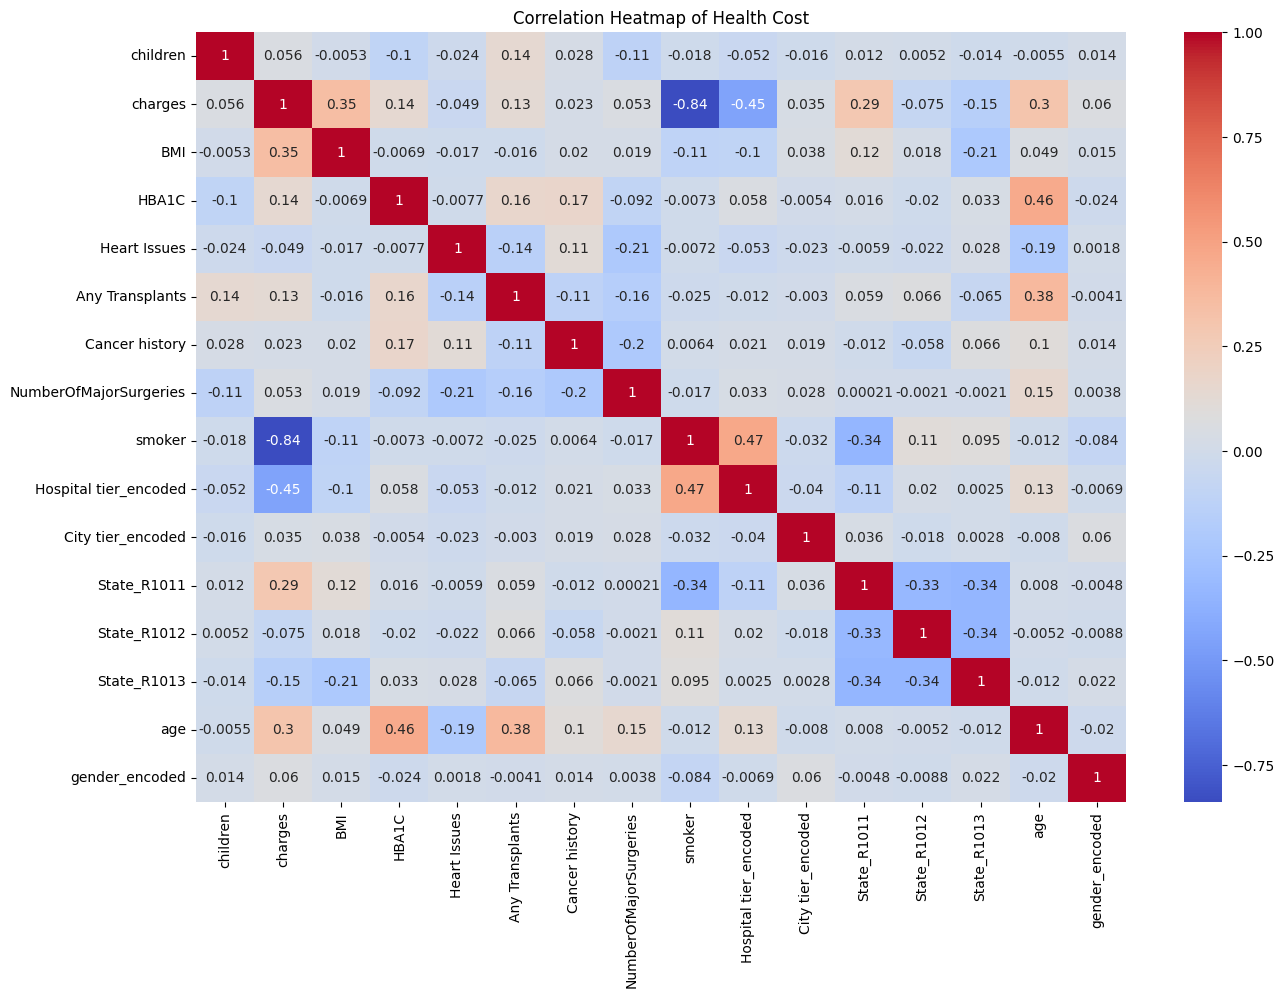

In [58]:

df_vis = merged_data.drop(columns=['Customer ID', 'year', 'month', 'day',
       'Hospital tier', 'City tier', 'State ID', 'name', 'dob', 'gender'])

# Calculate correlation matrix
correlation = df_vis.corr()
print(correlation)

# Create the heatmap using Seaborn for better control and colorbar
plt.figure(figsize=(15, 10))  # Set the figure size (adjust as needed)
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Health Cost")
plt.show()

## Regression modelling
Develop a regression model Linear or Ridge. Evaluate the model with k-fold cross validation.Also, ensure that you apply all the following suggestions:
•
Implement the stratified 5-fold cross validationtechnique for both model building and validation
•
Utilize effective standardization techniques and hyperparameter tuning
•
Incorporate sklearn-pipelines to streamline the workflow
•
Apply appropriate regularization techniques to address the bias-variance trade-off
•
Create five folds in the data, and introduce a variable to identify the folds
•
Develop Gradient Boost model and determine the variable importance scores,and identify the redundant variables

Split data

In [65]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
#Split data to test and train
X = df_vis.drop('charges', axis=1)  # Features
y = df_vis['charges']               # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Linear and Ridge regression
# Pipeline creation for standardization and modeling
# I have used two pipelines for the two models
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())  # Or Ridge()
])


# Use K Fold for cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Fit model within cross-validation loop (consider hyperparameter tuning)
for train_index, test_index in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    pipeline.fit(X_tr, y_tr)
    score = pipeline.score(X_val, y_val)
    print(f"KFold Score: {score}")


KFold Score: 0.8354979292132555
KFold Score: 0.8619909288985694
KFold Score: 0.8522422452011675
KFold Score: 0.859600534862711
KFold Score: 0.89847713872181
KFold Score: 0.8429360120957613
KFold Score: 0.8638520353778542
KFold Score: 0.886022659515102
KFold Score: 0.8254895341436217
KFold Score: 0.8967889334263194


Using K fold cross Validation.
This regression is not suitable for continuous data hence we will need to bin the target variable. My tgt variable is decimal(float)


In [60]:
from sklearn.impute import KNNImputer
#Split data to test and train
X = df_vis.drop('charges', axis=1)  # Features
y = df_vis['charges']               # Target variable
y.isnull().sum()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Linear and Ridge regression
# Pipeline creation for standardization and modeling
pipeline_strat = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())  # Or Ridge()
])

# Stratified K-Fold Cross-Validation
# Used 10 splits for data size and size on bins in charges
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Calculate the bin edges
bin_edges = np.linspace(y_train.min(), y_train.max(), 11)  # 11 edges for 10 bins

# Apply consistent binning to y_train and y_test
y_train = pd.cut(y_train, bins=bin_edges, labels=False)
y_test = pd.cut(y_test, bins=bin_edges, labels=False)
y_train.dropna(inplace=True)
# Get the aligned index for X_train
aligned_index = y_train.index
X_train = X_train.loc[aligned_index]



# Fit model within cross-validation loop (consider hyperparameter tuning)
for train_index, test_index in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    pipeline_strat.fit(X_tr, y_tr)
    score = pipeline_strat.score(X_val, y_val)
    print(f"Fold Score: {score}")

Fold Score: 0.84847500629437
Fold Score: 0.8391418813640701
Fold Score: 0.8451289447842717
Fold Score: 0.8641302276016605
Fold Score: 0.8389742853087855
Fold Score: 0.8294195775707982
Fold Score: 0.7755000248035279
Fold Score: 0.8463373518226062
Fold Score: 0.8473428419923634
Fold Score: 0.8404063019136858


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


## Gradient boosting Algo

The resulting featured list shows very low impact on transplant, surgeries, city_tier tec. View plot. But I have retained the same as regression model can take these.

RMSE: 3953.611206994061
R-squared: 0.8904177712069243
Mean Squared Error: 15631041.576069035


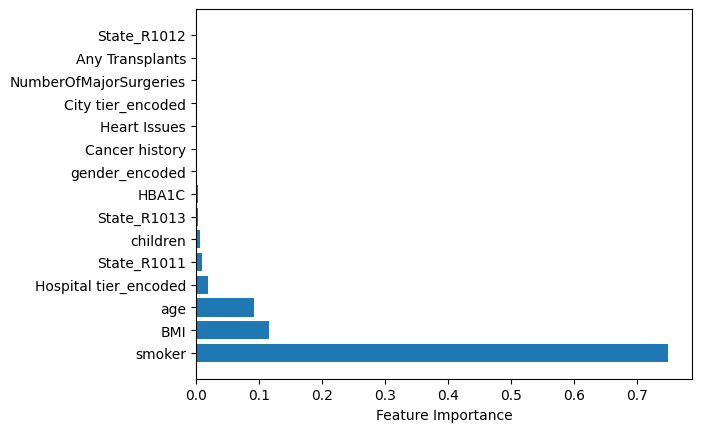

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor  # Or GradientBoostingClassifier for classification
from sklearn.metrics import mean_squared_error,r2_score  # Or other suitable regression metrics

#Gradient booting algo
#Split data to test and train
X = df_vis.drop('charges', axis=1)  # Features
y = df_vis['charges']               # Target variable
y.isnull().sum()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R-squared:", r2_score(y_test, y_pred))  # Results for my test data split
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))



# Get feature importances
feature_importances = gbr.feature_importances_

# Plot feature importances
feature_names = X.columns  # Assumes feature names are in X
sorted_indices = np.argsort(feature_importances)[::-1]

plt.barh(feature_names[sorted_indices], feature_importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.show()


## Prediction of test case
Estimate the cost of hospitalization for Christopher, Ms. Jayna (Dateof birth12/28/1988;height170 cm;and weight 85 kgs). She lives with her partner and two children in a tier-1 city,and her state’s State ID is R1011.She was found to be nondiabetic (HbA1c = 5.8). She smokes but is otherwise healthy. She has had no transplants or major surgeries. Her father died of lung cancer. Hospitalization costs will be estimated using tier-1 hospitals.

In [62]:
X.columns
X.head()
# Convert the patient data into dict. Use encoding followed
new_data = {'children':[2], 'BMI':[29.4], 'HBA1C':[5.8], 'Heart Issues':[1], 'Any Transplants':[1],
       'Cancer history':[1], 'NumberOfMajorSurgeries':[0], 'smoker':[0],
       'Hospital tier_encoded':[2], 'City tier_encoded':[2], 'State_R1011':[1],
       'State_R1012':[0], 'State_R1013':[0], 'age':[35.2], 'gender_encoded':[1]}

new_data = pd.DataFrame(new_data)


# Use best model to predict
#Using Kfold
prediction = pipeline.predict(new_data)  # Or gbr.predict()
print(f"Predicted Hospitalization Cost: {prediction[0]}")


Predicted Hospitalization Cost: 28076.992759026056


Save my df to csv file for use in tableau for data visualisation

In [63]:
merged_data.to_csv(file_path+'health_merged.csv', index=False)
df_vis.to_csv(file_path+'health_encoded.csv', index=False)
merged_data.shape

(2325, 26)